## Autodiff in `tf`
An toy function
$$
\begin{align}
  f(w_{1}, w_{2}) &= 3 w_{1}^2 + 2w_{1}w_{2} \\
  \nabla f(w_{1}, w_{2}) &= \begin{pmatrix}
    6w_{1} + 2w_{2} \\
    2w_{1}
  \end{pmatrix} \\
  \nabla f(5, 3) &= \begin{pmatrix}
    36 \\
    10
  \end{pmatrix} \\
\end{align}
$$

### Partial Derivatives by Definition

In [1]:
def f(w1, w2):
    return 3*w1**2 + 2*w1*w2

In [2]:
w1, w2 = 5, 3
eps = 1e-6

In [3]:
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [4]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

One drawback of this approach, as indicated by Aurelien, is that, for each partial derivative, say w.r.t. $w_{j}$, we need to evalution the function once at $f(w_{1}, \ldots, w_{j} + \epsilon, \ldots, w_{n})\,.$

Usually for a deep neural network, the number of parameters $w_{j}$ can be large, which means that we need to evaluate some function $f$ many many times. (In the most cases of DNN, $f$ is the cost function $J\,.$) This can quickly become expensive.

### Partial Derivatives by `tf.GradientTape`
Let's see how we can do this in `tf`.

In [5]:
import tensorflow as tf

In [6]:
# Notice the points after the numbers, they tell tf that these should be recognized as float, not int
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradient = tape.gradient(z, [w1, w2])
gradient

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

Wow, numerically `tf` gives closer results than our calculation by definition. A few of Aurelien's comments on this:

> - The precision is only limited by floating-point errors
> - only goes through the recoreded computation **once** (in reverse order), no matter how many independant variables there are
> - To save memory, only put the strict minimum inside the `with tf.GradientTape() as tape` block. Alternatively, pause recording by creating a `with tape.stop_recording()` block inside the `with tf.GradientTape() as tape` block.

Let's use `%%timeit` magic to measure the time for running both methods.

In [7]:
%%timeit
(f(w1 + eps, w2) - f(w1, w2)) / eps
(f(w1, w2 + eps) - f(w1, w2)) / eps

1.2 ms ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradient = tape.gradient(z, [w1, w2])
gradient

697 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The tape is automatically erased after you call its `gradient()` method, so you will get an exception if you try
to call `gradient()` twice:

In [9]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
print(f"dz_dw1 = {dz_dw1}")
print(f"type(dz_dw1) = {type(dz_dw1)}")
try:
    dz_dw2 = tape.gradient(z, w2)
    print(f"dz_dw2 = {dz_dw2}")
    print(f"type(dz_dw2) = {type(dz_dw2)}")
except RuntimeError as err:
    #print(f"{err.__class__}: {err}")
    print(f"RuntimeError: {err}")

dz_dw1 = 36.0
type(dz_dw1) = <class 'tensorflow.python.framework.ops.EagerTensor'>
RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.


As the error message above suggested, and as Aurelien further explained, if we need to call `gradient()` more than
once, we must make the tape persistent and **_delete it after we are done_** to **_free resources_**.

In [10]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, [w1])
print(f"dz_dw1 = {dz_dw1}")
dz_dw2 = tape.gradient(z, [w2])
print(f"dz_dw2 = {dz_dw2}")
del tape

dz_dw1 = [<tf.Tensor: shape=(), dtype=float32, numpy=36.0>]
dz_dw2 = [<tf.Tensor: shape=(), dtype=float32, numpy=10.0>]


By default, the tape will only track operations involving `tf.Variable`'s.

In [11]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradient = tape.gradient(z, [c1, c2])
gradient

[None, None]

However, we can force the tape to **_watch_** any tensors, enabling gradient calculations in this situation:

In [12]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradient = tape.gradient(z, [c1, c2])
gradient

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

The `tf.GradientTape()` thing we just experiencde is called **_reverse-mode autodiff_**. It only needs to do **_one forward pass_** and **_one backward pass_** in order to get all the gradients.

#### Gradient, Jacobian, Hessian
If our `f` is a vector-valued function instead of a scalar-valued function, i.e.

$$
  f: w \in \mathbb{R}^n \mapsto \left(f_{1}(w), \ldots, f_{m}(w)\right) \in \mathbb{R}^m\,,
$$

then

- `tape.gradient()` will compute the gradient of the sum $\sum_{i=1}^{m} f_{i}$ w.r.t. the $w_{j}$'s
- There is a `tape.jacobian()` method which will compute the Jacobian of $f$, i.e. the gradients of the $f_{i}$'s, **_in parallel_**
- It is even possible to compute the Hessian of a scalar-valued function.

Let's do the above-mentioned computations in `tf` for the following vector-valued function $g\,,$ and scalar-valued functions $h$:
$$
\begin{align}
  g:
  \begin{pmatrix}
    w_1 \\
    w_2
  \end{pmatrix} &\mapsto
  \begin{pmatrix}
    z_1 \\
    z_2 \\
    z_3
  \end{pmatrix} =
  \begin{pmatrix}
    f(w_1, w_2 + 2) \\
    f(w_1, w_2 + 5) \\
    f(w_1, w_2 + 7)
  \end{pmatrix} \\
  h:
  \begin{pmatrix}
    w_1 \\
    w_2
  \end{pmatrix} &\mapsto
  z_1 + z_2 + z_3 =
  f(w_1, w_2 + 2) +
  f(w_1, w_2 + 5) +
  f(w_1, w_2 + 7) \\
  \text{Jacobian}(g):
  \begin{pmatrix}
    w_1 \\
    w_2
  \end{pmatrix} &\mapsto
  \begin{pmatrix}
    6w_1 + 2(w_2 + 2) & 2w_1 \\
    6w_1 + 2(w_2 + 5) & 2w_1 \\
    6w_1 + 2(w_2 + 7) & 2w_1 \\
  \end{pmatrix} \\
  \nabla h:
  \begin{pmatrix}
    w_1 \\
    w_2
  \end{pmatrix} &\mapsto
  \begin{pmatrix}
    18w_1 + 6w_2 + 2(2+5+7) \\
    6w_1
  \end{pmatrix} \\
  \begin{pmatrix}
    5 \\
    3
  \end{pmatrix} &\mapsto
  \begin{pmatrix}
    136 \\
    30
  \end{pmatrix}
\end{align}
$$

In [13]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

# This should correspond to the promised gradient of the sum (z1 + z2 + z3)
gradient = tape.gradient([z1, z2, z3], [w1, w2])
gradient

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [14]:
# Let's also verify this numerically
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

jacobian = tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)])
gradient = tf.reduce_sum(jacobian, axis=0)
del tape
print(f"jacobian =\n{jacobian}")
print(f"gradient = {gradient}")

jacobian =
[[40. 10.]
 [46. 10.]
 [50. 10.]]
gradient = [136.  30.]


In [15]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as gradient_tape:
        z = f(w1, w2)
    gradient = gradient_tape.gradient(z, [w1, w2])
hessian = [hessian_tape.gradient(partial_derivative, [w1, w2])
           for partial_derivative in gradient]
del hessian_tape
print(f"gradient =\n{gradient}")
print(f"hessian =\n{hessian}")

gradient =
[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>, <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]
hessian =
[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>], [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]


$$
\begin{align}
  \text{Hessain}(f):
  \begin{pmatrix}
    w_1 \\
    w_2
  \end{pmatrix} &\mapsto
  \begin{pmatrix}
    6 & 2 \\
    2 & 0 \\
  \end{pmatrix} \\
\end{align}
$$

**Rmk.** Just like in Julia, the **_partial derivative of a constant function_** gives **`None`** in `tf`.

In [16]:
with tf.GradientTape() as tape:
    z = (lambda x: tf.constant(3.14159))(w1)

tape.gradient(z, w1) is None

True

We can ask `tf` to stop tracking gradient from some part of our neural network by using the `tf.stop_gradient()`.

During the forward pass, it still computes the part inside `tf.stop_gradient()`, whereas, during the backward
pass, it does not let gradient through. (It is **_as if that part equals some constant_**. Note that a constant's derivative equals `None` in `tf`.)

In [17]:
def ff(w1, w2):
    return 3*w1**2 + tf.stop_gradient(2*w1*w2)

with tf.GradientTape() as tape:
    z = ff(w1, w2)

gradient = tape.gradient(z, [w1, w2])
print(f"z = {z}")
print(f"gradient = {gradient}")

z = 105.0
gradient = [<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]


In [18]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradient = tape.gradient(z, [w1, w2])
print(f"z = {z}")
print(f"gradient = {gradient}")

z = 105.0
gradient = [<tf.Tensor: shape=(), dtype=float32, numpy=36.0>, <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]


#### Numerical Errors

In [19]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "axes.titlecolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black",
    "legend.edgecolor": "white",
    "legend.facecolor": "white",
})

In [20]:
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

`softplus` funciton is

- quite similar to `relu`, except that
  - it's smoother -- its derivative $z \mapsto \frac{e^z}{e^z + 1}$ is continuous on $\mathbb{R}\,.$
  - `softplus(0)` is not equal to `relu(0)`

In [21]:
my_softplus(0.)  # N.B. my_softplus(0) will produce error because of dtype inconsistency

<tf.Tensor: shape=(), dtype=float32, numpy=0.6931472>

In [22]:
import numpy as np

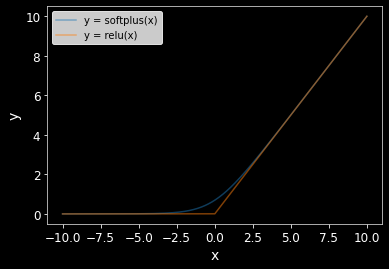

In [23]:
width = 10
n_points = 9_000
x = np.linspace(-width, width, n_points)
y = my_softplus(x).numpy()
yy = tf.keras.activations.relu(x).numpy()

alpha = 0.5
plt.plot(x, y, alpha=alpha, label="y = softplus(x)");
plt.plot(x, yy, alpha=alpha, label="y = relu(x)");
#plt.title("y = my_softplus(x)")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

Note that the curve of `relu` is the asymptotics of that of `softplus`. Indeed, $\text{softplus}'(z) = \frac{e^z}{e^z + 1}$ is an increasing function from $\frac{1}{2}$ to $1$ as $z$ goes from $0$ to $\infty\,.$

Let's calculate `softplus`' gradient.

In [24]:
z = tf.Variable(100.)
with tf.GradientTape() as tape:
    xi = my_softplus(z)

tape.gradient(xi, z)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

`nan`? What happened?

Aurelien said,
> Autodiff in the above case ends up computing infinity divided by infinity (which returns NaN).

Let's use Numpy to verify this.

In [25]:
np.exp(100.)

2.6881171418161356e+43

In [26]:
np.exp(100.) / np.exp(100.)

1.0

In [27]:
np.exp(100., dtype=np.float32)

/home/phunc20/.virtualenvs/tf2.2.0-torch1.6.0-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


inf

In [28]:
np.exp(100., dtype=np.float32) / np.exp(100., dtype=np.float32)

/home/phunc20/.virtualenvs/tf2.2.0-torch1.6.0-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
/home/phunc20/.virtualenvs/tf2.2.0-torch1.6.0-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in float_scalars
  """Entry point for launching an IPython kernel.


nan

In [29]:
np.exp(100., dtype=np.float64)

2.6881171418161356e+43

In [30]:
np.exp(100., dtype=np.float64) / np.exp(100., dtype=np.float64)

1.0

In [31]:
tf.float64, tf.float16, tf.float32

(tf.float64, tf.float16, tf.float32)

In [32]:
z = tf.Variable(100., dtype=tf.float64)
with tf.GradientTape() as tape:
    xi = my_softplus(z)

tape.gradient(xi, z)

<tf.Tensor: shape=(), dtype=float64, numpy=1.0>

So, more precisely speaking, this happens due to **`float32` _overflow_**.

### Workaround
Another, better, workaround for this is to find a more numerically stable formula for the derivative and then tell `tf` to use the found formula instead. Let's see closer how this is done.

If $\frac{e^z}{e^z + 1}$ causes overflow, its equivalent $\frac{e^z}{e^z + 1} = \frac{1}{1 + e^{-z}}$ won't cause overflow. Let's use this formula.

To inform `tf` of this, we

- rewrite the `softplus` function
- have the new function return
  - both the old return value of `softplus`
  - as well as a function whose input is $\frac{\partial J}{\partial (\text{so far})}$ and whose output is $\frac{\partial J}{\partial (\text{so far})} \cdot \frac{1}{1 + e^{-z}}\,,$ as if we are guiding `tf` through the differentiation of this part
- finally, we decorate the function with `@tf.custom_gradient`

In [33]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradient(grad):
        return grad / (1 + 1/exp)
    return tf.math.log(exp + 1), my_softplus_gradient

In [34]:
z = tf.Variable(100.)
with tf.GradientTape() as tape:
    xi = my_better_softplus(z)

tape.gradient(xi, z)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [35]:
z = tf.Variable(10.)
with tf.GradientTape() as tape:
    xi = my_better_softplus(z)

tape.gradient(xi, z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999546>

In [36]:
z = tf.Variable(10.)
with tf.GradientTape() as tape:
    xi = my_softplus(z)

tape.gradient(xi, z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.99995464>

It seems that overflow takes place at `89.` already.

In [37]:
z = tf.Variable(89.)
with tf.GradientTape() as tape:
    xi = my_softplus(z)

tape.gradient(xi, z)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [38]:
z = tf.Variable(89.)
with tf.GradientTape() as tape:
    xi = my_better_softplus(z)

tape.gradient(xi, z)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

One benefit of changing to this formula is that it even allows way larger `z` without ever worrying about overflow.

In [39]:
z = tf.Variable(1e38)
z.dtype

tf.float32

In [40]:
with tf.GradientTape() as tape:
    xi = my_better_softplus(z)

tape.gradient(xi, z)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [41]:
try:
    z = tf.Variable(1e39)
except ValueError as err:
    print(err)

Can't convert Python sequence with a value out of range for a double-precision float.


**(?)** Could you explain/review the reason for the above error?

In [43]:
def my_cheat_softplus(z):
    # one can think of tf.where() below as (in C/Julia)
    # z > 30.? z : tf.math.log(tf.exp(z) + 1.)
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [44]:
z = tf.Variable(100.)
with tf.GradientTape() as tape:
    xi = my_cheat_softplus(z)

tape.gradient(xi, z)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [45]:
xi, my_softplus(100.)

(<tf.Tensor: shape=(), dtype=float32, numpy=100.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=inf>)

In [46]:
z = tf.Variable(100.)
with tf.GradientTape() as tape:
    xi = (lambda t: t)(z)

tape.gradient(xi, z)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

**(?)** Could you explain why `my_cheat_softplus()` is not helping?